# Creating a high fidelity DeepChem dataset from experimental data

Suppose you were given data collected by an experimental collaborator.  You would like to use this data to construct a DeepChem model.  

*How do you transform this data into a dataset capable of creating a useful DeepChem model?*

Building models from novel data can present several challenges.  Perhaps the data was not recorded in a convenient manner.  Additionally, perhaps the data contains noise.  This is a common occurance with, for example, biological assays due to the large number of external variables and the difficulty and cost associated with collecting multiple samples.  This is a problem because you do not want your model to fit to this noise.

Hence, there are two primary challenges:
* Parsing data
* De-noising data
    
In this tutorial, will walk through an example of curating a dataset from an excel spreadsheet of experimental drug  measurements.

## Parsing data

In order to read in the data, we will use the pandas data analysis library.  

In order to convert the drug names into smiles strings, we will use pubchempy.

In [1]:
import os
import pandas as pd
from pubchempy import get_cids, get_compounds

Pandas is magic but it doesn't automatically know where to find your data of interest.  You likely will have to look at it first using a GUI.  

We will now look at a screenshot of this dataset as rendered by LibreOffice.

To do this, we will import Image and os.

In [2]:
import os
from IPython.display import Image, display

In [3]:
current_dir = os.path.dirname(os.path.realpath('__file__'))

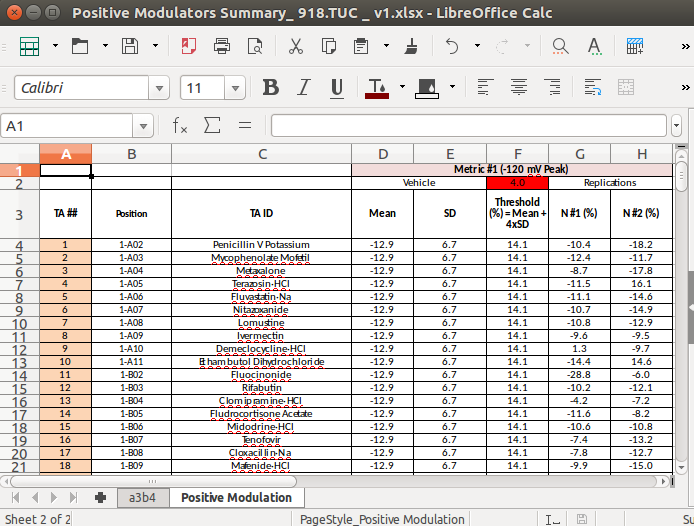

In [4]:
data_screenshot = os.path.join(current_dir, 'assets/dataset_preparation_gui.png')
display(Image(filename=data_screenshot))

We see the data of interest is on the second sheet, and contained in columns "TA ID", "N #1 (%)", and "N #2 (%)".

Additionally, it appears much of this spreadsheet was formatted for human readability (multicolumn headers, column labels with spaces and symbols, etc.).  This makes the creation of a neat dataframe object harder.  For this reason we will cut everything that is unnecesary or inconvenient.

In [5]:
raw_data_file = os.path.join(current_dir, '../../datasets/Positive Modulators Summary_ 918.TUC _ v1.xlsx')
raw_data_excel = pd.ExcelFile(raw_data_file)

# second sheet only
raw_data = raw_data_excel.parse(raw_data_excel.sheet_names[1])

In [6]:
# preview 5 rows of raw dataframe
raw_data.loc[raw_data.index[:5]]

,,,Metric #1 (-120 mV Peak),Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
NaN,NaN,NaN,Vehicle,NaN,4,Replications,NaN
TA ##,Position,TA ID,Mean,SD,Threshold (%) = Mean + 4xSD,N #1 (%),N #2 (%)
1,1-A02,Penicillin V Potassium,-12.8689,6.74705,14.1193,-10.404,-18.1929
2,1-A03,Mycophenolate Mofetil,-12.8689,6.74705,14.1193,-12.4453,-11.7175
3,1-A04,Metaxalone,-12.8689,6.74705,14.1193,-8.65572,-17.7753


In [7]:
# remove column labels (rows 0 and 1), as we will replace them
# only take data given in columns "N #1 (%)" (3) and "N #2 (%)" (4)
raw_data = raw_data.iloc[2:, [3, 4]]

# collapse multiindex so that drug names and number indexes are columns
raw_data.reset_index(level=[1, 2], inplace=True)

# rename columns
raw_data.columns = ['label', 'drug', 'n1', 'n2']

In [8]:
# preview cleaner dataframe
raw_data.loc[raw_data.index[:5]]

,label,drug,n1,n2
1,1-A02,Penicillin V Potassium,-10.404,-18.1929
2,1-A03,Mycophenolate Mofetil,-12.4453,-11.7175
3,1-A04,Metaxalone,-8.65572,-17.7753
4,1-A05,Terazosin·HCl,-11.5048,16.0825
5,1-A06,Fluvastatin·Na,-11.1354,-14.553


This formatting is closer to what we need.

Now, let's take the drug names and get smiles strings for them (format needed for DeepChem).

In [9]:
drugs = raw_data['drug'].values

For many of these, we can retreive the smiles string via the canonical_smiles attribute of the get_compounds object

In [10]:
get_compounds(drugs[1], 'name')

[Compound(5281078)]

In [11]:
get_compounds(drugs[1], 'name')[0].canonical_smiles

u'CC1=C(C(=C(C2=C1COC2=O)O)CC=C(C)CCC(=O)OCCN3CCOCC3)OC'

However, some of these drug names have variables spaces and symbols (·, (±), etc.), and names that may not be readable by pubchempy. 

For this task, we will do a bit of hacking via regular expressions.  Also, we notice that all ions are written in a shortened form that will need to be expanded.  For this reason we use a dictionary, mapping the shortened ion names to versions recognizable to pubchempy.  

Unfortunately you may have several corner cases that will require more hacking.

In [12]:
ion_replacements = {
    'HBr': ' hydrobromide',
    '2Br': ' dibromide',
    'Br': ' bromide',
    'HCl': ' hydrochloride',
    '2H2O': ' dihydrate',
    'H20': ' hydrate',
    'Na': ' sodium'
}

ion_keys = ['H20', 'HBr', 'HCl', '2Br', '2H2O', 'Br', 'Na']

In [13]:
import re

In [14]:
def compound_to_smiles(cmpd):
    # remove spaces and irregular characters
    compound = re.sub(r'([^\s\w]|_)+', '', cmpd)
                   
    # replace ion names if needed
    for ion in ion_keys:
        if ion in compound:
            compound = compound.replace(ion, ion_replacements[ion])

    # query for cid first in order to avoid timeouterror
    cid = get_cids(compound, 'name')[0]
    smiles = get_compounds(cid)[0].canonical_smiles

    return smiles

In [15]:
smiles_map = {}
for i in drugs:
    smiles_map[i] = compound_to_smiles(i)

In [16]:
smiles_data = raw_data
# map drug name to smiles string
smiles_data['drug'] = smiles_data['drug'].apply(lambda x: smiles_map[x])

In [17]:
# preview smiles data
smiles_data.loc[smiles_data.index[:5]]

,label,drug,n1,n2
1,1-A02,CC1(C(N2C(S1)C(C2=O)NC(=O)COC3=CC=CC=C3)C(=O)[...,-10.404,-18.1929
2,1-A03,CC1=C(C(=C(C2=C1COC2=O)O)CC=C(C)CCC(=O)OCCN3CC...,-12.4453,-11.7175
3,1-A04,CC1=CC(=CC(=C1)OCC2CNC(=O)O2)C,-8.65572,-17.7753
4,1-A05,COC1=C(C=C2C(=C1)C(=NC(=N2)N3CCN(CC3)C(=O)C4CC...,-11.5048,16.0825
5,1-A06,CC(C)N1C2=CC=CC=C2C(=C1C=CC(CC(CC(=O)[O-])O)O)...,-11.1354,-14.553


Hooray, we have mapped each drug name to its corresponding smiles code.

Now, we need to look at the data and remove as much noise as possible.

## De-noising data

In machine learning, we know that there is no free lunch.  You will need to spend time analyzing and understanding your data in order to frame your problem and determine the appropriate model framework.  Treatment of your data will depend on the conclusions you gather from this process.

Questions to ask yourself:
* What are you trying to accomplish?
* What is your assay?
* What is the structure of the data?
* Does the data make sense?
* What has been tried previously?

For this project (respectively):
* I would like to build a model capable of predicting the affinity of an arbitrary small molecule drug to a particular ion channel protein
* For an input drug, data describing channel inhibition
* A few hundred drugs, with n=2
* Will need to look more closely at the dataset*
* Nothing on this particular protein

*This will involve plotting, so we will import matplotlib and seaborn.  We will also need to look at molecular structures, so we will import rdkit.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

In [19]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase

In [22]:
# i will use numpy on occasion for manipulating arrays
import numpy as np

Our goal is to build a small molecule model, so let's make sure our molecules are all small.  This can be approximated by the length of each smiles string.

In [20]:
smiles_data['len'] = [len(i) for i in smiles_data['drug']]

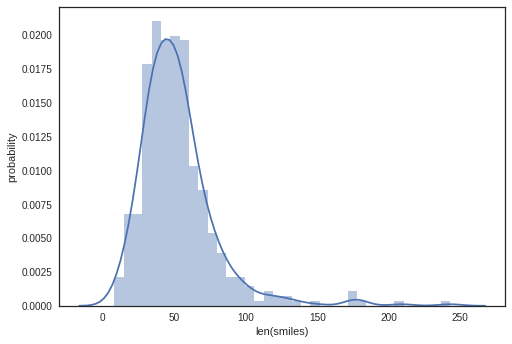

In [21]:
smiles_lens = [len(i) for i in smiles_data['drug']]
sns.distplot(smiles_lens)
plt.xlabel('len(smiles)')
plt.ylabel('probability')

Some of these look rather large, len(smiles) > 150.  Let's see what they look like.

In [23]:
# indices of large looking molecules
suspiciously_large = np.where(np.array(smiles_lens) > 150)[0]

# corresponding smiles string
long_smiles = smiles_data.loc[smiles_data.index[suspiciously_large]]['drug'].values

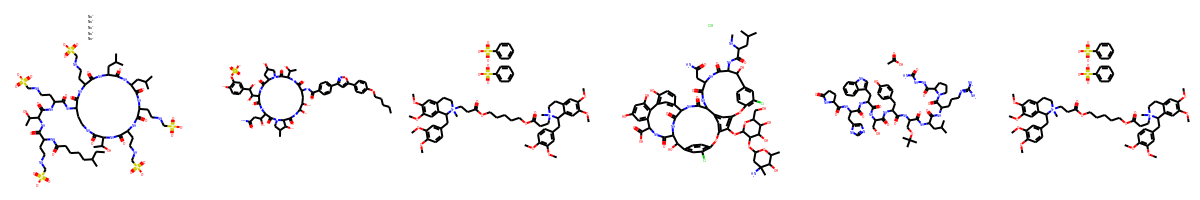

In [25]:
# look
Draw._MolsToGridImage([Chem.MolFromSmiles(i) for i in long_smiles], molsPerRow=6)

As suspected, these are not small molecules, so we will remove them from the dataset.  The argument here is that these molecules could register as inhibitors simply because they are large.  They are more likely to sterically blocks the channel, rather than diffuse inside and bind (which is what we are interested in).

The lesson here is to remove data that does not fit your use case.

In [26]:
# drop large molecules
smiles_data = smiles_data[~smiles_data['drug'].isin(long_smiles)]

Now, let's look at the numerical structure of the dataset.

First, check for NaNs.

In [27]:
nan_rows = smiles_data[smiles_data.isnull().T.any().T]
nan_rows[['n1', 'n2']]

,n1,n2
63,NaN,-7.8266
176,NaN,-6.61225
188,NaN,-8.23326
234,-8.21781,NaN
263,NaN,-12.8788
289,NaN,-2.34264
301,NaN,-8.19936
302,NaN,-10.4633
312,NaN,-8.78722
396,-5.32572,-1.7599


I don't trust n=1, so I will throw these out.  

Then, let's examine the distribution of n1 and n2.

In [28]:
df = smiles_data.dropna(axis=0, how='any')

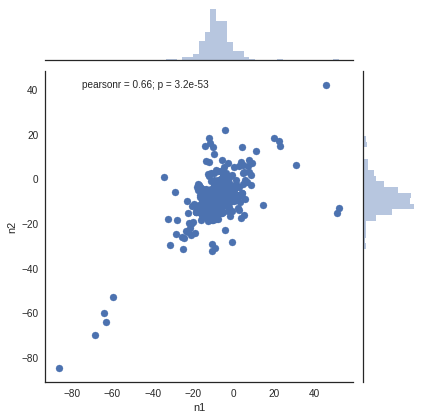

In [29]:
# seaborn jointplot will allow us to compare n1 and n2, and plot each marginal
sns.jointplot('n1', 'n2', data=smiles_data) 

We see that most of the data is contained in the gaussian-ish blob centered a bit below zero.  We see that there are a few clearly active datapoints located in the bottom left, and one on the top right.  These are all distinguished from the majority of the data.  How do we handle the data in the blob?  

Because n1 and n2 represent the same measurement, ideally they would be of the same value.  This plot should be tightly aligned to the diagonal, and the pearson correlation coefficient should be 1.  We see this is not the case.  This helps gives us an idea of the error of our assay.

Let's look at the error more closely, plotting in the distribution of (n1-n2).

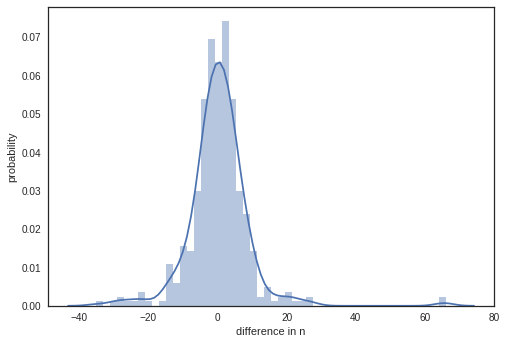

In [30]:
diff_df = df['n1'] - df['n2']

sns.distplot(diff_df)
plt.xlabel('difference in n')
plt.ylabel('probability')

This looks pretty gaussian, let's get the 95% confidence interval by fitting a gaussian via scipy, and taking 2*the standard deviation

In [31]:
from scipy import stats

In [32]:
mean, std = stats.norm.fit(diff_df)

In [33]:
ci_95 = std*2
ci_95

17.803505462981775

Now, I don't trust the data outside of the confidence interval, and will therefore drop these datapoints from df.  

For example, in the plot above, at least one datapoint has n1-n2 > 60.  This is disconcerting.

In [34]:
noisy = diff_df[abs(diff_df) > ci_95]
df = df.drop(noisy.index)

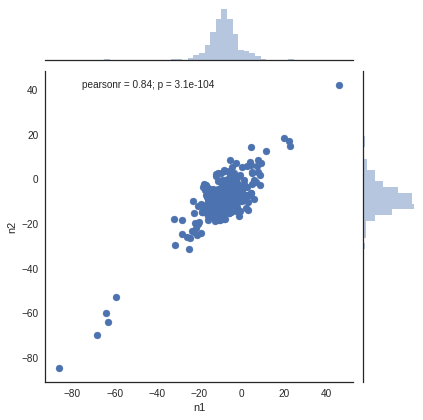

In [35]:
sns.jointplot('n1', 'n2', data=df) 

Now that data looks much better!

So, let's average n1 and n2, and take the error bar to be ci_95.

In [36]:
avg_df = df[['label', 'drug']]
n_avg = df[['n1', 'n2']].mean(axis=1)
avg_df['n'] = n_avg
avg_df.sort_values('n', inplace=True)

/home/kmckiern/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kmckiern/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Now, let's look at the sorted data with error bars.

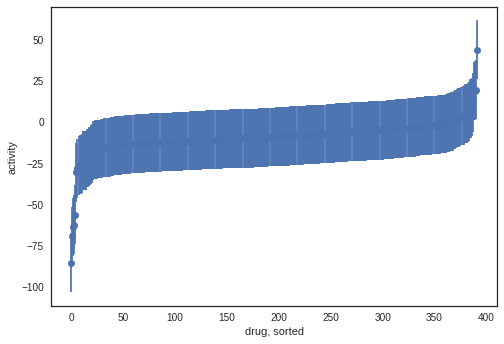

In [37]:
plt.errorbar(np.arange(avg_df.shape[0]), avg_df['n'], yerr=ci_95, fmt='o')
plt.xlabel('drug, sorted')
plt.ylabel('activity')

Now, let's identify our active compounds.  

In my case, this required domain knowledge.  Having worked in this area, and having consulted with professors specializing on this channel, I am interested in compounds where the absolute value of the activity is greater than 25.  This relates to the desired drug potency we would like to model.

If you are not certain how to draw the line between active and inactive, this cutoff could potentially be treated as a hyperparameter.

<Container object of 3 artists>

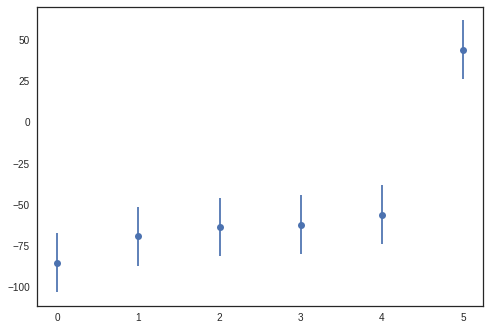

In [38]:
actives = avg_df[abs(avg_df['n'])-ci_95 > 25]['n']

plt.errorbar(np.arange(actives.shape[0]), actives, yerr=ci_95, fmt='o')

In [39]:
# summary
print (raw_data.shape, avg_df.shape, len(actives.index))

((430, 5), (392, 3), 6)


In summary, we have:
* Removed data that did not address the question we hope to answer (small molecules only)
* Dropped NaNs
* Determined the noise of our measurements
* Removed exceptionally noisy datapoints
* Identified actives (using domain knowledge to determine a threshold)

## Determine model type, final form of dataset, and sanity load

Now, what model framework should we use?  

Given that we have 392 datapoints and 6 actives, this data will be used to build a low data one-shot classifier (10.1021/acscentsci.6b00367).  If there were datasets of similar character, transfer learning could potentially be used, but this is not the case at the moment.


Let's apply logic to our dataframe in order to cast it into a binary format, suitable for classification.

In [40]:
# 1 if condition for active is met, 0 otherwise
avg_df['active'] = (abs(avg_df['n'])-ci_95 > 25).astype(int)

/home/kmckiern/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Now, save this to file.

In [41]:
avg_df.to_csv('modulators.csv', index=False)

Now, we will convert this dataframe to a DeepChem dataset.

In [42]:
import deepchem as dc

In [43]:
dataset_file = 'modulators.csv'
task = ['active']
featurizer_func = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=task, smiles_field='drug', featurizer=featurizer_func)
dataset = loader.featurize(dataset_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from modulators.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.897 s
TIMING: dataset construction took 1.621 s
Loading dataset from disk.


Lastly, it is often advantageous to numerically transform the data in some way.  For example, sometimes it is useful to normalize the data, or to zero the mean.  This depends in the task at hand.

Built into DeepChem are many useful transformers, located in the deepchem.transformers.transformers base class. 

Because this is a classification model, and the number of actives is low, I will apply a balancing transformer.  I treated this transformer as a hyperparameter when I began training models.  It proved to unambiguously improve model performance.

In [44]:
transformer = dc.trans.BalancingTransformer(transform_w=True, dataset=dataset)
dataset = transformer.transform(dataset)

TIMING: dataset construction took 1.066 s
Loading dataset from disk.


Now let's save the balanced dataset object to disk, and then reload it as a sanity check.

In [45]:
dc.utils.save.save_to_disk(dataset, 'balanced_dataset.joblib')
balanced_dataset = dc.utils.save.load_from_disk('balanced_dataset.joblib')

Tutorial written by Keri McKiernan (github.com/kmckiern) on September 8, 2016